In [1]:
%%markdown
## Exercise 1

Consider the coin tossing example, discussed in the first lecture. Simulate 1000 tosses of the coins, setting $H = 0.3$. Consider a uniform prior and update the posterior at each toss. Plot the resulting posterior after 1, 50,100, 300, 700, 1000 tosses. Repeat the simulated experiment by setting
a Gaussian prior centered in $H = 0.5$, with standard deviation $\sigma = 0.1$.
Do both posteriors converge a similar distribution in the end? What does that mean? Which posterior converges faster and why?

## Exercise 1

Consider the coin tossing example, discussed in the first lecture. Simulate 1000 tosses of the coins, setting $H = 0.3$. Consider a uniform prior and update the posterior at each toss. Plot the resulting posterior after 1, 50,100, 300, 700, 1000 tosses. Repeat the simulated experiment by setting
a Gaussian prior centered in $H = 0.5$, with standard deviation $\sigma = 0.1$.
Do both posteriors converge a similar distribution in the end? What does that mean? Which posterior converges faster and why?


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
# we will need this to make an interactive plot
# for the updating of the posterior

np.random.seed(42)
# to ensure reproducibility

In [3]:
def simulate_heads(heads_probability: float, number_tosses: int = 1) -> int:
    """
    Simulates number_tosses coin tosses (default: 1)
    of a generic, potentially unfair coin, whose probability
    of yielding heads is heads_probability

    Return the number of times the result of the toss was heads.
    """

    uniform = np.random.uniform(low=0., high=1., size=number_tosses)
    return(np.sum(uniform < heads_probability))

def binomial_distribution(heads_probability: np.ndarray, number_heads: int, number_tosses: int)-> float:
    """
    Calculate the values of a binomial distribution: 

    p(H) = H**N_H * (1-H)**(N - N_H)

    up to a proportionality constant.

    where:
        H = heads_probability,
        N_H = number_heads,
        N = number_tosses.
    
    The function is optimized for heads_probability to be a vector,
    and the returned probabilities are normalized so that
    the maximum of the heads_probability
    evaluated at the selected points is 1.
    """

    log_distribution = (number_heads * np.log(heads_probability) +
    (number_tosses - number_heads) * np.log(1 - heads_probability))
    
    log_distribution -= np.max(log_distribution)
    # normalize right now: allows for much greater numerical stability 
    
    return(np.exp(log_distribution))

In [4]:
"""
Simulate N_max coin tosses for an unfair coin 
with heads probability equal to H, keeping track of the running total
of heads results. 
"""

H = .3
N_max = 2000

heads = []
heads_running_total=0
for n in range(N_max):
    h = simulate_heads(H)
    heads_running_total += h
    heads.append(heads_running_total)

In [5]:
# generate a vector of samples of our parameter, the probability to obtain heads
eps =1e-12
H_samples = np.linspace(0+eps, 1-eps, num=1000)
# since we work with log-likelihoods and such, some fudging of the boundaries is needed
# in order to achieve numerical stability

# we work with two possible choices of prior: a flat one and a Gaussian one
# here we define the Gaussian prior with mean 0.5 and standard deviation 0.1,
# without normalization since we will normalize later anyway
gaussian_prior = np.exp(- (H_samples - .5)**2 / 2 / .1**2)

def plot(toss_number):
    """
    Given a toss_number, which should be between 0 and N_max-1
    generate a plot of the posterior pdfs we find starting from a 
    Gaussian posterior and a flat posterior.
    Both are normalized to have a maximum of 1, in order for 
    the plot to remain clear as they become more peaky.
    So, the y-axis only has meaning up to a constant.

    Uses variables heads, H_samples and gaussian_prior
    from the environment, this is not good practice but it makes
    things simpler for the interactive plot.
    """

    try:
        likelihood = binomial_distribution(H_samples, heads[toss_number], toss_number)
    except(IndexError):
        print(f'We have not simulated {toss_number} tosses!')
        return(None)
    posterior_flat_prior = np.copy(likelihood)
    posterior_gaussian_prior = gaussian_prior * likelihood
    posterior_gaussian_prior /= np.max(posterior_gaussian_prior)
    plt.plot(H_samples, posterior_flat_prior, label='Flat prior')
    plt.plot(H_samples, posterior_gaussian_prior, label='Gaussian prior')
    plt.axvline(H, c='black', label='True value')
    plt.xlabel('Heads probability')
    plt.ylabel('Unnormalized posterior probability')
    plt.legend()
    return(None)

# this generates an interactive plot,
# with a slider allowing one to vary the number of tosses.

interact(plot, toss_number=(0,N_max -1,1))

interactive(children=(IntSlider(value=999, description='toss_number', max=1999), Output()), _dom_classes=('wid…

<function __main__.plot(toss_number)>

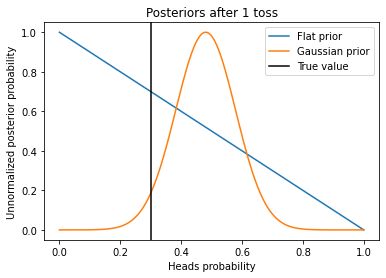

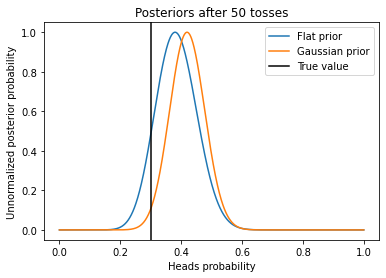

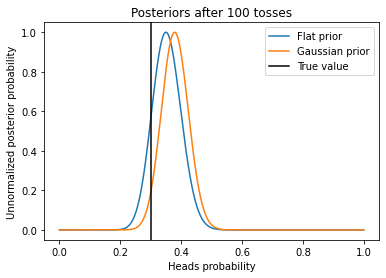

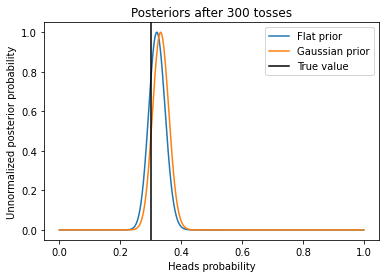

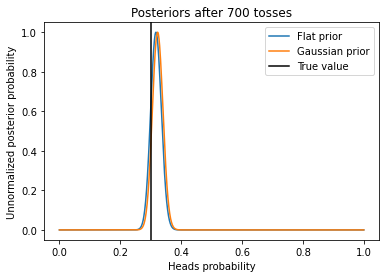

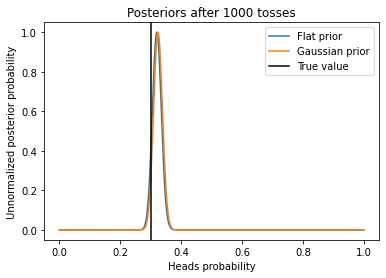

In [6]:
# Here are the required plots

chosen_toss_numbers = [1, 50,100, 300, 700, 1000]
for n in chosen_toss_numbers:
    plot(n)
    suffix = '' if n==1 else 'es'
    plt.title(f'Posteriors after {n} toss{suffix}')
    plt.show()

In [7]:
%%markdown
Both posteriors converge to very similar distributions in the end;
as we add more and more data the prior becomes less and less relevant,
it is "washed out" by the data.

In the early stages it seems that the narrower prior stays more narrow than the flat prior,
while also being usually more wrong (since it was rather unrepresentative of the true value).
Let us quantify this.

Both posteriors converge to very similar distributions in the end;
as we add more and more data the prior becomes less and less relevant,
it is "washed out" by the data.

In the early stages it seems that the narrower prior stays more narrow than the flat prior,
while also being usually more wrong (since it was rather unrepresentative of the true value).
Let us quantify this.


In [8]:
from scipy.integrate import trapz
# standard integration, adding the areas of the trapezoids

def mean_std_of_pdf(x, pdf):
    """
    Given a sampled probability distribution pdf, 
    whose points correspond to the values x for the random variable,
    this function returns its mean and standard deviation
    in the same units as x.
    """

    pdf_integral = trapz(y=pdf, x=x)
    pdf /= pdf_integral
    # first we must normalize

    mean = trapz(y=pdf * x, x=x)
    std = np.sqrt(trapz(y=pdf * (x-mean)**2, x=x))
    return(mean, std)

"""
For the two different different priors,
and for each number of coin tosses,
we calculate the standard deviation of the posterior
and its relative error, computed as
(distribution_mean - true_mean) / standard_deviation
"""

sigmas_flat = []
sigmas_gaussian= []
error_flat = []
error_gaussian = []

for toss_number in range(N_max):

    likelihood = binomial_distribution(H_samples, heads[toss_number], toss_number)
    
    posterior_flat_prior = np.copy(likelihood) # already normalized
    posterior_gaussian_prior = gaussian_prior * likelihood
    posterior_gaussian_prior /= np.max(posterior_gaussian_prior)

    mean_flat, std_flat = mean_std_of_pdf(H_samples, posterior_flat_prior)
    mean_gaussian, std_gaussian = mean_std_of_pdf(H_samples, posterior_gaussian_prior)

    sigmas_flat.append(std_flat)
    sigmas_gaussian.append(std_gaussian)
    error_flat.append((mean_flat - H) / std_flat)
    error_gaussian.append((mean_gaussian - H) / std_gaussian)

Text(0, 0.5, 'Standard deviation')

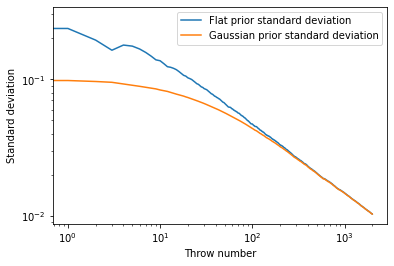

In [9]:
# We plot the standard deviations of the two posteriors
# and see that they converge to the same N**(-1/2) powerlaw in terms of 
# the number of tosses.

plt.loglog(sigmas_flat, label='Flat prior standard deviation')
plt.loglog(sigmas_gaussian, label='Gaussian prior standard deviation')
plt.legend()
plt.xlabel('Throw number')
plt.ylabel('Standard deviation')

Text(0, 0.5, 'Relative error')

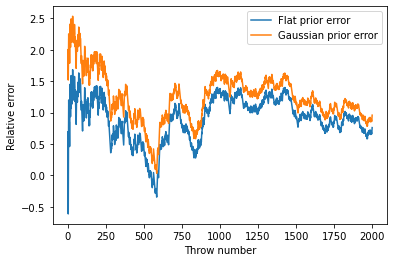

In [10]:
# We plot the relative errors of the two distributions,
# as expected they remain of order 1 even as the 
# standard deviation decreases.

# Also, we can see that they get ever closer: 
# the prior will have ever less relevance
# as the number of tosses increases.

plt.plot(error_flat, label='Flat prior error')
plt.plot(error_gaussian, label='Gaussian prior error')
plt.legend()
plt.xlabel('Throw number')
plt.ylabel('Relative error')

In [11]:
%%markdown
## Problem 2
Politician $A$ makes a statement about some issue you knew nothing about before. Let’s call such proposition $S$ and assume your starting prior on $S$ is uniform with 0.5 probability of $S$ being either true or false. Update your probability of $S$ being true, knowing that you trust Mr. A to tell the truth with probability $\text{prob}(A_T ) = 4/5$. At this point Mr $B$ - another politician - declares that he agrees with Mr $A$ on $S$ being true. You trust Mr. $B$ much less, and believe that the probability of him to lie is $\text{prob}(B_F ) = 3/4$.
What is your final degree of belief in proposition S?

## Problem 2
Politician $A$ makes a statement about some issue you knew nothing about before. Let’s call such proposition $S$ and assume your starting prior on $S$ is uniform with 0.5 probability of $S$ being either true or false. Update your probability of $S$ being true, knowing that you trust Mr. A to tell the truth with probability $\text{prob}(A_T ) = 4/5$. At this point Mr $B$ - another politician - declares that he agrees with Mr $A$ on $S$ being true. You trust Mr. $B$ much less, and believe that the probability of him to lie is $\text{prob}(B_F ) = 3/4$.
What is your final degree of belief in proposition S?


In [12]:
P_A_T = 4./5. 
# probability that A tells the truth

likelihood = P_A_T
# probability that A said S, given that S is true
# equals the probability that S will tell the truth

prior = .5 
# prior probability that S is true

evidence = likelihood * prior + (1-likelihood) * (1- prior)
# probability that A said S, independently of S
# written as P(A | S) P(S) + P(A | not S) P(not S)
# and P(A | not S) is the probability that A said something false

posterior = likelihood * prior / evidence
# Bayes' theorem

print(f'The posterior probability after A said S is {posterior}')

The posterior probability after A said S is 0.8


In [13]:
prior_2 = posterior
# the old posterior becomes the new prior

P_B_T = 1./4.
likelihood_2 = P_B_T
# probability that B said S, given that S is true

evidence_2 = likelihood_2 * prior_2 + (1-likelihood_2) * (1 - prior_2)
# probability that B said S, independently of S
# written as P(B | S) P(S) + P(B | not S) P(not S)
# and P(B | not S) is the probability that B said something false

posterior_2 = likelihood_2 * prior_2 / evidence_2
# Bayes' theorem

print(f'The posterior probability after both B and A said S is {posterior_2:.2f}')

The posterior probability after both B and A said S is 0.57


In [14]:
%%markdown

We can use an alternative approach, using an equation derived from considering 
Bayes' theorem 
$$
\mathbb{P}(A | B) = \frac{\mathbb{P}(B | A) \mathbb{P}(A)}{\mathbb{P}(B)}
$$
and Bayes' theorem applied to the proposition $\text{not } A$: 
$$
\mathbb{P}(\text{not } A| B) = \frac{\mathbb{P}(B | \text{not } A) \mathbb{P}(\text{not } A)}{\mathbb{P}(B)}
\,.
$$

Dividing one equation by the other we find that the $\mathbb{P}(B)$
term simplifies, so we have:
$$
\underbrace{\frac{\mathbb{P}(A|B)}{\mathbb{P}(\text{not } A | B)} }_{\text{posterior}} =
\underbrace{\frac{\mathbb{P}(B|A)}{\mathbb{P}(B | \text{not } A)}}_{BF}
\underbrace{\frac{\mathbb{P}(A)}{\mathbb{P}(\text{not } A)}}_{\text{prior}}
\,.
$$

If we interpret $A$ as a statement, while $B$ represents data, we can readily identify the prior and posterior: they are expressed in terms of odds,
ratios of the probability of an even to the probability of its negation.

It is convenient to work in terms of the logarithm of these quantities: these are the _log-odds_,
which can take any value from $- \infty$ to $\infty$,
with the value 0 representing a flat distribution: $1/2$ probability for both the statement and its counter.

Then, we can find the posterior log-odds by adding the logarithm of the Bayes Factor to the prior log-odds.

We can then see that the Bayes Factor quantifies evidence in an understandable, additive way.
If we used base-2 logarithms we could talk of _bits_ of evidence in an information-theoretic sense.


We can use an alternative approach, using an equation derived from considering 
Bayes' theorem 
$$
\mathbb{P}(A | B) = \frac{\mathbb{P}(B | A) \mathbb{P}(A)}{\mathbb{P}(B)}
$$
and Bayes' theorem applied to the proposition $\text{not } A$: 
$$
\mathbb{P}(\text{not } A| B) = \frac{\mathbb{P}(B | \text{not } A) \mathbb{P}(\text{not } A)}{\mathbb{P}(B)}
\,.
$$

Dividing one equation by the other we find that the $\mathbb{P}(B)$
term simplifies, so we have:
$$
\underbrace{\frac{\mathbb{P}(A|B)}{\mathbb{P}(\text{not } A | B)} }_{\text{posterior}} =
\underbrace{\frac{\mathbb{P}(B|A)}{\mathbb{P}(B | \text{not } A)}}_{BF}
\underbrace{\frac{\mathbb{P}(A)}{\mathbb{P}(\text{not } A)}}_{\text{prior}}
\,.
$$

If we interpret $A$ as a statement, while $B$ represents data, we can readily identify the prior and posterior: they are expressed in terms of odds,
ratios of the probability of an even to the probability of its negation.

It is convenient to work in terms of the logarithm of these quantities: these are the _log-odds_,
which can take any value from $- \infty$ to $\infty$,
with the value 0 representing a flat distribution: $1/2$ probability for both the statement and its counter.

Then, we can find the posterior log-odds by adding the logarithm of the Bayes Factor to the prior log-odds.

We can then see that the Bayes Factor quantifies evidence in an understandable, additive way.
If we used base-2 logarithms we could talk of _bits_ of evidence in an information-theoretic sense.


In [15]:
# Alternative approach, using log-odds

def log_odds(p):
    return(np.log(p) - np.log(1-p))

def probability(lo):
    return(np.exp(lo) / (1 + np.exp(lo)))

log_prior = log_odds(prior)

log_bayes_factor_1 = log_odds(P_A_T)
log_bayes_factor_2 = log_odds(P_B_T)
# a special case, due to the fact that A and B
# lie or tell the truth independently of the topic
# in general the Bayes factor would be
# BF = P(A | S) / P(A | not S)

# now comes the magic: the log-posterior is calculated simply 
# by adding the bayes-factors from all the observations
log_posterior = log_bayes_factor_1 + log_bayes_factor_2 + log_prior

posterior_alternative = probability(log_posterior)

print(f'The posterior calculated this way is {posterior_alternative:.2f}')

equal_or_not = 'equal' if np.isclose(posterior_alternative, posterior_2) else 'not equal'

print(f'It is {equal_or_not} to the posterior calculated with the regular approach')



The posterior calculated this way is 0.57
It is equal to the posterior calculated with the regular approach


In [16]:
%%markdown
## Problem 3
You are tested for a dangerous disease named ”Bacillum Bayesianum”
(BB). You test positive to BB. You know that the general incidence of BB in the population is 1%. Moreover, you know that your test has a false negative probability of 5% (false negative: you have BB but the test scores negative), and a false positive rate also of 5% (false positive: you do not have BB, but the test scores positive). What is the probability that you have actually contracted BB?

## Problem 3
You are tested for a dangerous disease named ”Bacillum Bayesianum”
(BB). You test positive to BB. You know that the general incidence of BB in the population is 1%. Moreover, you know that your test has a false negative probability of 5% (false negative: you have BB but the test scores negative), and a false positive rate also of 5% (false positive: you do not have BB, but the test scores positive). What is the probability that you have actually contracted BB?


In [17]:
prior_BB = .5
false_negative = .3
false_positive = .05

true_positive = 1 - false_negative
true_negative = 1 - false_positive

# this time we directly take the log-odds approach

log_prior_BB = log_odds(prior_BB)
log_bayes_factor_BB = np.log(true_positive / false_positive)
log_bayes_factor_BB_negative_test = - np.log(true_negative / false_negative)
# always referring to the statement 
# "you have BB"

log_posterior_BB = log_bayes_factor_BB + log_prior_BB
posterior_BB = probability(log_posterior_BB)
print(f'The probability of having BB after having tested positive is {posterior_BB:.2f}')

log_posterior_BB_2 = log_bayes_factor_BB_negative_test + log_prior_BB
posterior_BB_2 = probability(log_posterior_BB_2)
print(f'The probability of having BB after having tested negative is {posterior_BB_2:.2f}')



The probability of having BB after having tested positive is 0.93
The probability of having BB after having tested negative is 0.24


In [18]:
print(f'Log-prior = {log_prior_BB:.2f}')
print(f'Log-BF = {log_bayes_factor_BB:.2f}')
print(f'Log-posterior = {log_posterior_BB:.2f}')

print(f'Log-BF of a negative test: {log_bayes_factor_BB_negative_test:.2f}')

Log-prior = 0.00
Log-BF = 2.64
Log-posterior = 2.64
Log-BF of a negative test: -1.15


In [19]:
%%markdown
This formalism allows us to see more easily how much more evidence would
sway our belief: the log-odds of the prior are about $-4.5$, while the
log-BF for each positive test gives us about 3 units of evidence to the
fact that we have the disease.

Since the false negative and false positive probabilities are equal, 
a negative test sways our belief by the exact opposite amount as a positive test.
If we test negative once and then positive once, our belief will be
equal to the prior. 

This formalism allows us to see more easily how much more evidence would
sway our belief: the log-odds of the prior are about $-4.5$, while the
log-BF for each positive test gives us about 3 units of evidence to the
fact that we have the disease.

Since the false negative and false positive probabilities are equal, 
a negative test sways our belief by the exact opposite amount as a positive test.
If we test negative once and then positive once, our belief will be
equal to the prior. 


-0.8649974374866044


Text(0.5, 1.0, 'False negative rate: 0.4, false positive rate: 0.05')

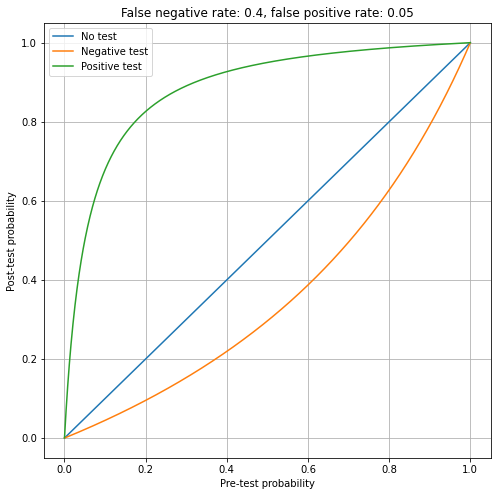

In [25]:
pre_test = np.linspace(1e-5,1-1e-5, num=1000)
fnr =.4
fpr = .05

def post_negative(pre, fnr=fnr, fpr=fpr, n=1):
    odds = log_odds(pre)
    log_bf = np.log(fnr / (1 - fpr))
    print(log_bf)
    return(probability(odds + log_bf * n))

def post_positive(pre, fnr=fnr, fpr=fpr, n=1):
    odds = log_odds(pre)
    log_bf = np.log((1-fnr) / fpr)
    return(probability(odds + log_bf * n))


plt.figure(figsize=(8, 8))
plt.plot(pre_test, pre_test, label='No test')
plt.plot(pre_test, post_negative(pre_test, n=1), label='Negative test')
plt.plot(pre_test, post_positive(pre_test, fpr), label='Positive test')
plt.grid()
plt.legend()
plt.xlabel('Pre-test probability')
plt.ylabel('Post-test probability')
plt.title(f'False negative rate: {fnr}, false positive rate: {fpr}')